### It is interesting to visualize how the data domain is split into in-domain and out-of-domain regions. We will try to visualize this in 2-D with PCA.

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")
    
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from utils.domain_split import hyperplane_split

In [2]:
df = pd.read_csv("data/regression/airfoil.csv")
df.head()

,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Get the indices to split the data to domain and OOD 

In [3]:
dom_idx, OOD_idx, n, c = hyperplane_split(df.values, OOD_size=0.2, verbose=1, return_plane=True)

Found random direction n = [-0.13984336  0.36403187 -0.18693442  0.6678697  -0.60333712 -0.05398644]
Found split with ratio r = 0.20093147039254824


Hyperplane equation
$$ n^T x + c = 0 $$

### Normalize and transform data, split into in-domain and OOD.

In [4]:
# scale/normalize data
preprocessing = "normalize"
scaler = StandardScaler() if preprocessing=="normalize" else MinMaxScaler()
D = scaler.fit_transform(df.values)

# PCA  (applying on the full space which includes the target variable)
pca = PCA(2)
D_pca = pca.fit_transform(D)

# split domain
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]
# X_dom, target_dom = D_dom[:, :-1], D_dom[:, -1]
# X_dom_pca, target_dom_pca = D_dom_pca[:, :-1], D_dom_pca[:, -1]
# Χ_ood, target_ood = D_ood[:, :-1], D_ood[:, -1]
# Χ_ood_pca, target_ood_pca = D_ood_pca[:, :-1], D_ood_pca[:, -1]

### To visualize the split, we will try to visualize the separating hyperplane.

To plot the projection of the hyperplane, we select points lying on the hyperplane and project them to the 2-D space.

To find such points, we need to find a basis of the hyperplane. It suffices to construct an orthogonal basis of the original data space whose first basis vector is $n$. That way, the rest of the basis vectors will all be orthogonal to $n$, and as such they will span the hyperplane. 

One way to obtain this basis is to rotate the standard basis so that $e_1$ aligns with $n$. We use the [Rodrigues rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) to find the rotation matrix $R$:

$$ R = 2 \frac{(a+b)(a+b)^T}{(a+b)^T(a+b)} - I $$

In [5]:
def rodrigues_formula(a, b):
    nom = np.outer(a+b, a+b)
    denom = np.dot(a+b, a+b)
    R = 2 * nom / denom - np.eye(len(a))
    
    return R

Then we rotate the standard basis of $\mathbb{R}^n = <e_1, \dots, e_n>$. Rotating the standard basis is actually trivial, since $\mathbb{I}_n = [e_1, \dots, e_n], R \cdot \mathbb{I}_n = R$, so the new orthogonal basis is just the columns of $R$ (remember that the first column of $R$ is the vector $n$, which was chosen randomly in the domain splitting routine). 

In [6]:
e_1 = np.eye(len(n))[0]
R = rodrigues_formula(e_1, n)
U = R         # basis U is R*I = I

We obtain points $x$ on the hyperplane in the following way: 

First we initialize $x = c\cdot n$, so that $x$ lies on the hyperplane. Then we add to $x$ possible linear combinations of the other basis vectors $$ x = x + \sum_{i>1} \lambda_i u_i, \ \ \ \ \ \text{(i indexes all columns except the first one)} $$where $u_i$ are the columns of U (basis vectors).

To avoid making costly calculations since we are in high dimensions, we then proceed to randomly sample the coefficients uniformly from double the data range 
$$\lambda_i \sim U( \ \ 2 min( X[:,i]), \ 2 max( X[:,i]) \ \ ) $$ 
and generate points $x$

$$ x = cn + \sum_{i>1} \lambda_i u_i $$

In [7]:
def sample_hyperplane(no_points=100):
    """
    Randomly samples points that lie on the hyperplane.
    """
    points = []
    for t in range(no_points):
        lmbda = npr.uniform( 2 * D.min(axis=0), 2 * D.max(axis=0))
        lmbda[0] = 0.       # drop the coefficient corresponding to n
        x = -c*n            # initialize vector on the hyperplane (the hypeprlane seems to be opposite of where n is facing)

        for i in range(len(n)):
            x += lmbda[i] * U[:, i]

        points.append(x)
    P = np.asarray(points)
    
    return P

P = sample_hyperplane(100)

### Sanity check
Make sure the points we pick truly lie on the hyperplane. This is true if they satisfy the hyperplane equation.

In [8]:
# Pick a random point
m = npr.randint(0, len(P))

# Calculate hyperplane equation
dot = np.dot(P[m], n) + c

# Should be 0
print( np.isclose(0, dot) )

True


### Project the points to 2-D

In [9]:
P_pca = pca.transform(P)

### Plot them

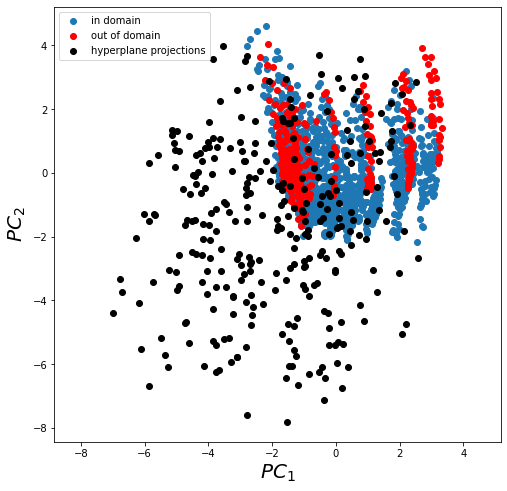

In [10]:
P = sample_hyperplane(300)
P_pca = pca.transform(P)

plt.figure(figsize=(8,8))

plt.scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
plt.scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
plt.scatter(P_pca[:,0], P_pca[:,1], c='k', alpha=1, label="hyperplane projections")
plt.legend()
plt.xlabel(r"$PC_1$", fontsize=20)
plt.ylabel(r"$PC_2$", fontsize=20)
plt.axis('equal')
plt.show()

### Repeat with more points on the hyperplane

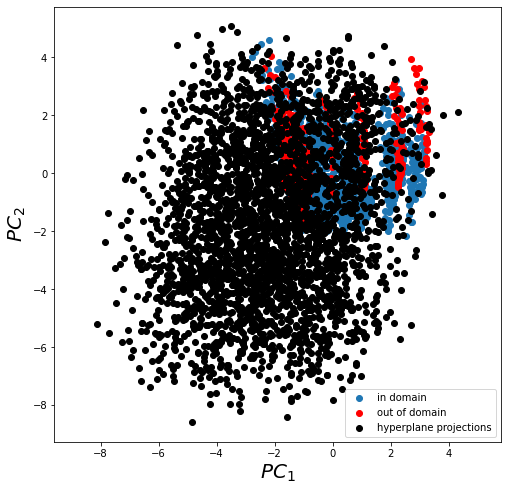

In [11]:
P = sample_hyperplane(3000)
P_pca = pca.transform(P)

plt.figure(figsize=(8,8))

plt.scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
plt.scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
plt.scatter(P_pca[:,0], P_pca[:,1], c='k', alpha=1, label="hyperplane projections")
plt.legend()
plt.xlabel(r"$PC_1$", fontsize=20)
plt.ylabel(r"$PC_2$", fontsize=20)
plt.axis('equal')
plt.show()

### It doesn't seem to give any insights, at least for this dataset.

### Let's look at how the domain is split into in-domain and OOD for random directions $n$.

Found random direction n = [ 0.02416075 -0.65382684  0.73878916  0.01257714  0.01053403 -0.16077357]
Found split with ratio r = 0.20093147039254824


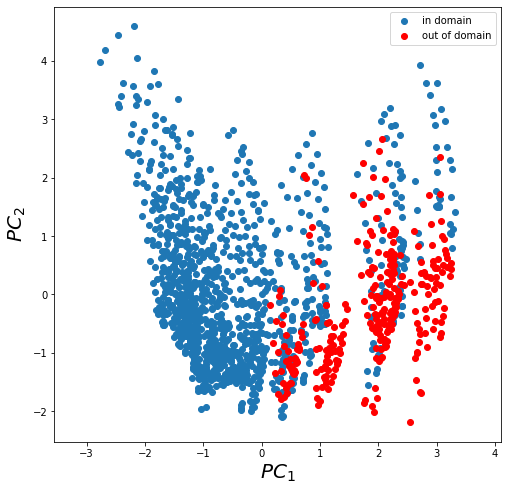

In [12]:
dom_idx, OOD_idx, n, c = hyperplane_split(df.values, OOD_size=0.2, verbose=1, return_plane=True)

D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

plt.figure(figsize=(8,8))

plt.scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
plt.scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")

plt.legend()
plt.xlabel(r"$PC_1$", fontsize=20)
plt.ylabel(r"$PC_2$", fontsize=20)
plt.axis('equal')
plt.show()

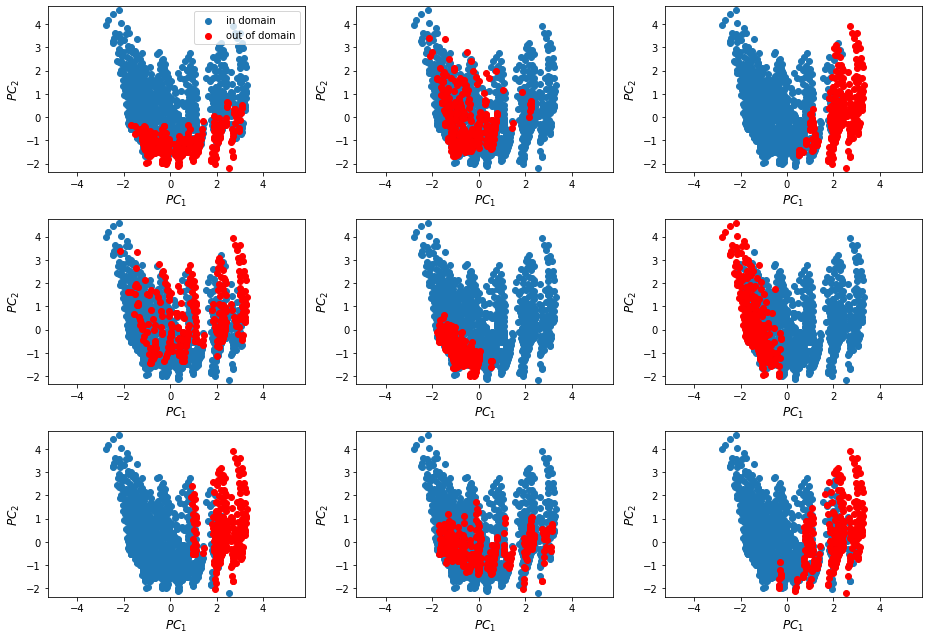

In [16]:
fig, ax = plt.subplots(3,3, figsize=(13,9))

dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[0,0].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[0,0].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[0,0].legend()
ax[0,0].set_xlabel(r"$PC_1$", fontsize=12)
ax[0,0].set_ylabel(r"$PC_2$", fontsize=12)
ax[0,0].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[0,1].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[0,1].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[0,1].set_xlabel(r"$PC_1$", fontsize=12)
ax[0,1].set_ylabel(r"$PC_2$", fontsize=12)
ax[0,1].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[0,2].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[0,2].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[0,2].set_xlabel(r"$PC_1$", fontsize=12)
ax[0,2].set_ylabel(r"$PC_2$", fontsize=12)
ax[0,2].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[1,0].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[1,0].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[1,0].set_xlabel(r"$PC_1$", fontsize=12)
ax[1,0].set_ylabel(r"$PC_2$", fontsize=12)
ax[1,0].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[1,1].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[1,1].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[1,1].set_xlabel(r"$PC_1$", fontsize=12)
ax[1,1].set_ylabel(r"$PC_2$", fontsize=12)
ax[1,1].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[1,2].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[1,2].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[1,2].set_xlabel(r"$PC_1$", fontsize=12)
ax[1,2].set_ylabel(r"$PC_2$", fontsize=12)
ax[1,2].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[2,0].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[2,0].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[2,0].set_xlabel(r"$PC_1$", fontsize=12)
ax[2,0].set_ylabel(r"$PC_2$", fontsize=12)
ax[2,0].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[2,1].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[2,1].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[2,1].set_xlabel(r"$PC_1$", fontsize=12)
ax[2,1].set_ylabel(r"$PC_2$", fontsize=12)
ax[2,1].axis('equal')


dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2)
D_dom, D_ood = D[dom_idx], D[OOD_idx]
D_dom_pca, D_ood_pca = D_pca[dom_idx], D_pca[OOD_idx]

ax[2,2].scatter(D_dom_pca[:,0], D_dom_pca[:,1], label="in domain")
ax[2,2].scatter(D_ood_pca[:,0], D_ood_pca[:,1], c="r", label="out of domain")
ax[2,2].set_xlabel(r"$PC_1$", fontsize=12)
ax[2,2].set_ylabel(r"$PC_2$", fontsize=12)
ax[2,2].axis('equal')

plt.tight_layout()
plt.show()

In [14]:
# blank space for scrolling below